In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    cohen_kappa_score,
    classification_report
)

from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Analysis: 2nd part

In [3]:
df_llm = pd.read_csv('../datasets/llm_logodds.csv')
df_bert = pd.read_csv('../datasets/recipes_with_logodds_lists.csv')
df_hum = pd.read_csv('../datasets/human_labelling.csv')
bert=pd.read_csv('../datasets/llm_bert_clusters.csv')

In [4]:
bert=bert.merge(df_llm[['title','avg_ingredients_logodd','avg_verbs_logodd','avg_title_logodd','avg_prompt_logodd','avg_other_logodd']], on='title')

In [5]:
bert=bert.merge(df_hum[['title','HumanLabelling']],on='title')

In [6]:
df=bert.merge(df_bert[['title','avg_ing_logodds', 'avg_verb_logodds','avg_title_logodds']], on='title')

In [7]:
df.rename(columns={'HumanLabelling':'humanlabel'},inplace=True)

## Descriptive

In [7]:
print(f"BERT right, LLM right {len(df[(df['hier'] == df['humanlabel']) & (df['naed'] == df['humanlabel'])])}")
print(f"BERT wrong, LLM right {len(df[(df['hier'] != df['humanlabel']) & (df['naed'] == df['humanlabel'])])}")
print(f"BERT right, LLM wrong {len(df[(df['hier'] == df['humanlabel']) & (df['naed'] != df['humanlabel'])])}")
print(f"BERT wrong, LLM wrong {len(df[(df['hier'] != df['humanlabel']) & (df['naed'] != df['humanlabel'])])}")

BERT right, LLM right 421
BERT wrong, LLM right 282
BERT right, LLM wrong 89
BERT wrong, LLM wrong 208


In [8]:
df['set_verbs']=df['filtered_verbs'].apply(set)

In [9]:
import re

def fix_ner_list(val):
    if isinstance(val, str):
        val = val.strip("[]")
        parts = re.findall(r"'(.*?)'", val)
        return [p.strip() for p in parts]
    return val

df['NER_list'] = df['NER_list'].apply(fix_ner_list)
df['filtered_verbs'] = df['filtered_verbs'].apply(fix_ner_list)

In [10]:
df['prompt'] = df.apply(
    lambda row: row['title'].lower() + ' ' +
                ' '.join([x for x in row['NER_list']]) + ' ' +
                ' '.join([x for x in row['set_verbs']]),
    axis=1
)

In [11]:
df_base=df.copy()

## Jaccard Similarity

Ratio of the intersection of sets of words and the union of the sets of words.

In [12]:
def tokenize(text):
    return set(text.lower().split())

def get_cluster_token_sets(cluster_col):
    token_sets = {}
    for label, group in df.groupby(cluster_col):
        all_text = " ".join(group['prompt'])
        token_sets[label] = tokenize(all_text)
    return token_sets

## Right LLM wrong BERT

In [115]:
df=df_base.copy()

In [116]:
df=df[(df['hier'] != df['humanlabel']) & (df['naed'] == df['humanlabel'])].copy()

### Confusion Matrix

In [117]:
confusion = pd.crosstab(df['naed'], df['hier'], rownames=['LLM'], colnames=['BERT'])
print(confusion)

BERT   1   2   3  4   5   6  7
LLM                           
1      0   6   2  1  20   1  1
2     80   0  14  0   0   0  0
3      0  11   0  2   2   1  0
4      2   3   9  0  20  11  6
5      1   2   2  4   0  25  8
6      0   0   0  1   7   0  0
7      0   0   1  7  12  20  0


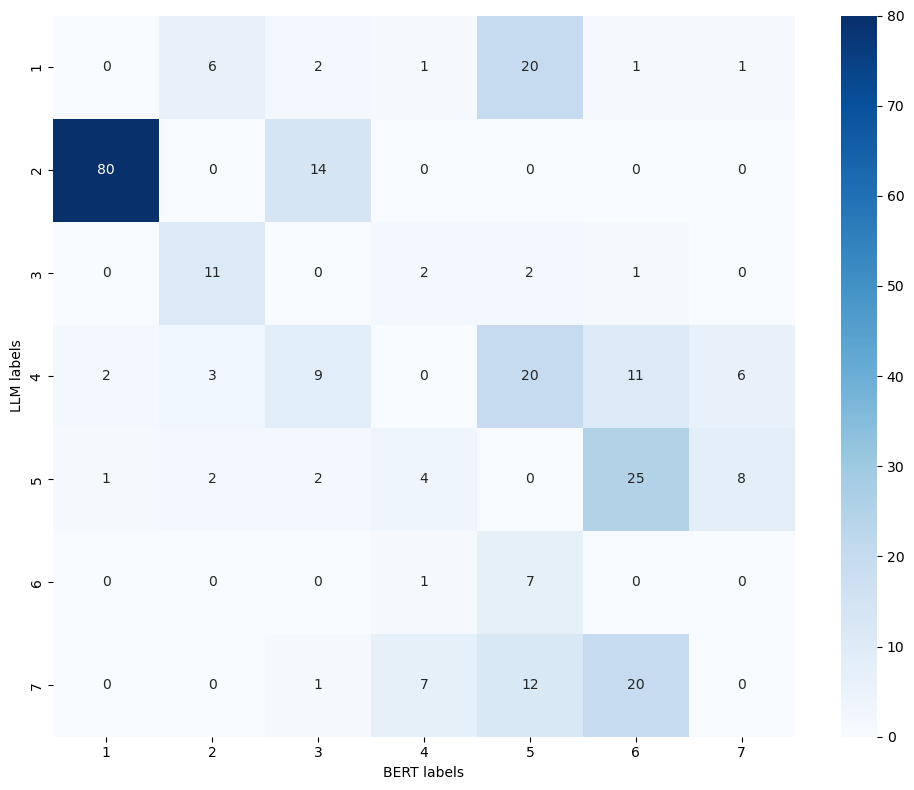

In [118]:
confusion = pd.crosstab(df['naed'], df['hier'], rownames=['LLM'], colnames=['BERT'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.ylabel('LLM labels')
plt.xlabel('BERT labels')
plt.tight_layout()
plt.show()


#### Human labels and BERT

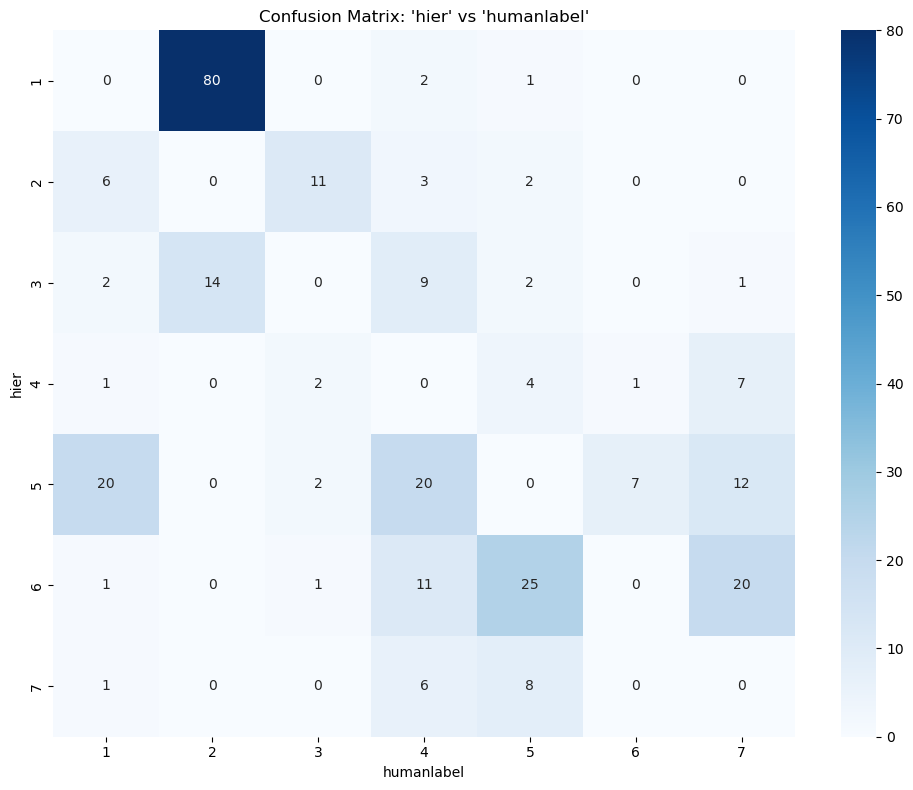

In [119]:
# 1. Create the confusion matrix as a DataFrame
confusion = pd.crosstab(df['hier'], df['humanlabel'], rownames=['hier'], colnames=['humanlabel'])

# 2. Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title("Confusion Matrix: 'hier' vs 'humanlabel'")
plt.ylabel('hier')
plt.xlabel('humanlabel')
plt.tight_layout()
plt.show()


In [99]:
from collections import defaultdict
import pandas as pd

naed_tokens = get_cluster_token_sets('naed')
hier_tokens = get_cluster_token_sets('hier')

jaccard_matrix = defaultdict(dict)

for n_label, n_tokens in naed_tokens.items():
    for h_label, h_tokens in hier_tokens.items():
        intersection = len(n_tokens & h_tokens)
        union = len(n_tokens | h_tokens)
        jaccard = intersection / union if union > 0 else 0
        jaccard_matrix[n_label][h_label] = jaccard
        
        # Print numerator and denominator
        print(f"Jaccard({n_label}, {h_label}) = {intersection} / {union} = {jaccard:.4f}")

# Optional: convert to DataFrame for visualization
jaccard_df = pd.DataFrame(jaccard_matrix).T.sort_index(axis=0).sort_index(axis=1)
print(jaccard_df)

Jaccard(1, 1) = 92 / 465 = 0.1978
Jaccard(1, 2) = 100 / 281 = 0.3559
Jaccard(1, 3) = 85 / 321 = 0.2648
Jaccard(1, 4) = 80 / 292 = 0.2740
Jaccard(1, 5) = 157 / 391 = 0.4015
Jaccard(1, 6) = 108 / 444 = 0.2432
Jaccard(1, 7) = 74 / 277 = 0.2671
Jaccard(2, 1) = 331 / 389 = 0.8509
Jaccard(2, 2) = 90 / 454 = 0.1982
Jaccard(2, 3) = 140 / 429 = 0.3263
Jaccard(2, 4) = 63 / 472 = 0.1335
Jaccard(2, 5) = 97 / 614 = 0.1580
Jaccard(2, 6) = 91 / 624 = 0.1458
Jaccard(2, 7) = 63 / 451 = 0.1397
Jaccard(3, 1) = 68 / 408 = 0.1667
Jaccard(3, 2) = 103 / 197 = 0.5228
Jaccard(3, 3) = 57 / 268 = 0.2127
Jaccard(3, 4) = 66 / 225 = 0.2933
Jaccard(3, 5) = 77 / 390 = 0.1974
Jaccard(3, 6) = 78 / 393 = 0.1985
Jaccard(3, 7) = 53 / 217 = 0.2442
Jaccard(4, 1) = 107 / 548 = 0.1953
Jaccard(4, 2) = 85 / 394 = 0.2157
Jaccard(4, 3) = 123 / 381 = 0.3228
Jaccard(4, 4) = 98 / 372 = 0.2634
Jaccard(4, 5) = 193 / 453 = 0.4260
Jaccard(4, 6) = 169 / 481 = 0.3514
Jaccard(4, 7) = 105 / 344 = 0.3052
Jaccard(5, 1) = 87 / 512 = 0.1699
Jac

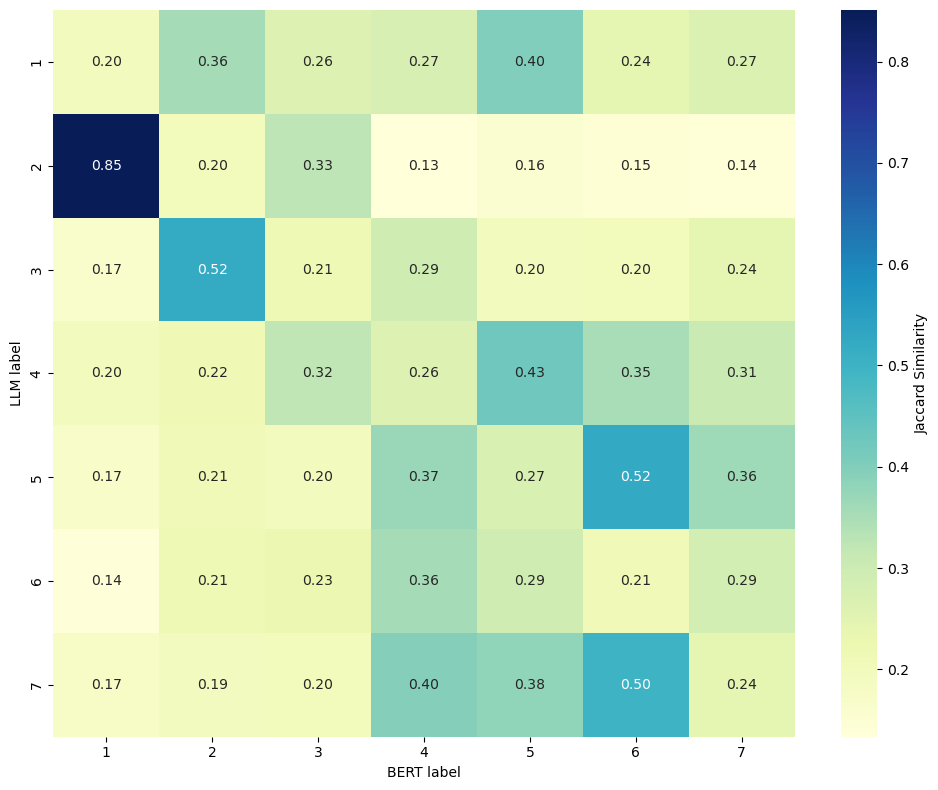

In [120]:
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Jaccard Similarity'})
plt.xlabel('BERT label')
plt.ylabel('LLM label')
plt.tight_layout()
plt.savefig('../images/jaccard_Rllm_Wbert.png')
plt.show()

## Wrong LLM, right BERT

In [121]:
df=df_base.copy()
df=df[(df['hier'] == df['humanlabel']) & (df['naed'] != df['humanlabel'])]

### Confusion Matrix

In [122]:
confusion = pd.crosstab(df['naed'], df['hier'], rownames=['LLM'], colnames=['BERT'])
print(confusion)

BERT  1  2  3  4  5  6  7
LLM                      
1     0  6  1  2  4  0  4
2     1  0  4  1  3  0  0
3     0  6  0  2  1  0  0
4     0  2  1  0  9  0  3
5     4  3  0  3  0  2  9
6     0  1  1  2  3  0  1
7     0  0  0  3  3  4  0


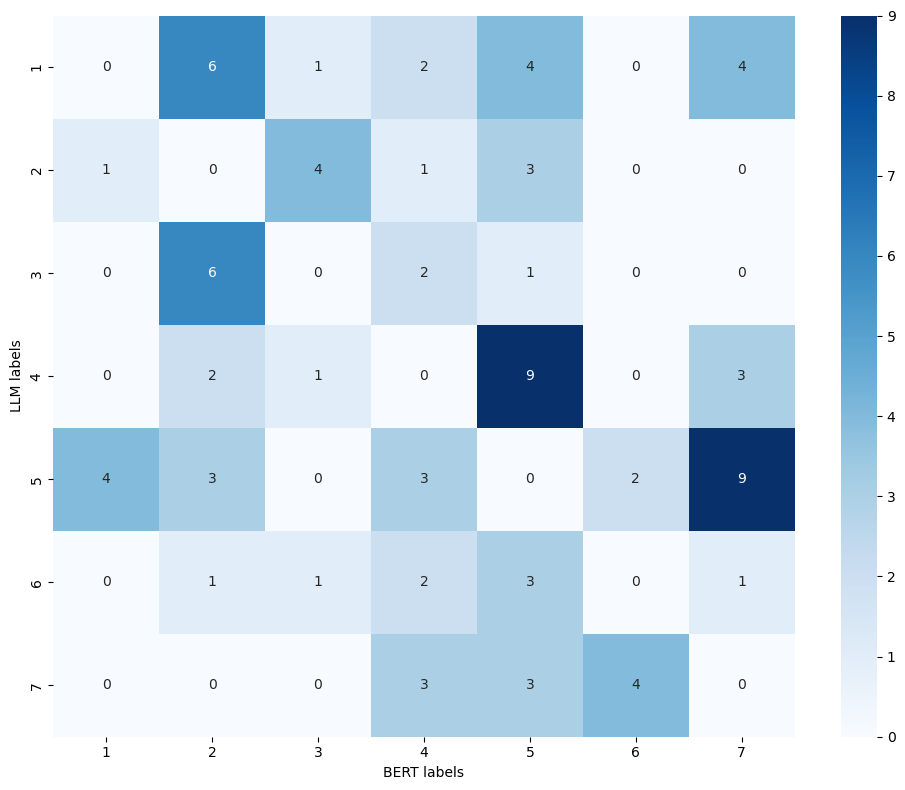

In [123]:
confusion = pd.crosstab(df['naed'], df['hier'], rownames=['LLM'], colnames=['BERT'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.ylabel('LLM labels')
plt.xlabel('BERT labels')
plt.tight_layout()
plt.show()

In [124]:
naed_tokens = get_cluster_token_sets('naed')
hier_tokens = get_cluster_token_sets('hier')

jaccard_matrix = defaultdict(dict)

for n_label, n_tokens in naed_tokens.items():
    for h_label, h_tokens in hier_tokens.items():
        intersection = len(n_tokens & h_tokens)
        union = len(n_tokens | h_tokens)
        jaccard_matrix[n_label][h_label] = intersection / union if union > 0 else 0
        
jaccard_df = pd.DataFrame(jaccard_matrix).T.sort_index(axis=0).sort_index(axis=1)
print(jaccard_df)

          1         2         3         4         5         6         7
1  0.241026  0.422727  0.262376  0.311404  0.389558  0.221675  0.367347
2  0.442623  0.273196  0.442748  0.273224  0.308411  0.181818  0.206278
3  0.250000  0.450867  0.304054  0.362069  0.245614  0.215686  0.213333
4  0.209040  0.278027  0.282486  0.284360  0.452055  0.208791  0.389140
5  0.323529  0.286792  0.209402  0.362500  0.316901  0.277778  0.557940
6  0.288889  0.282723  0.307692  0.350877  0.293023  0.267606  0.302439
7  0.219355  0.181818  0.195266  0.413793  0.382075  0.560000  0.270270


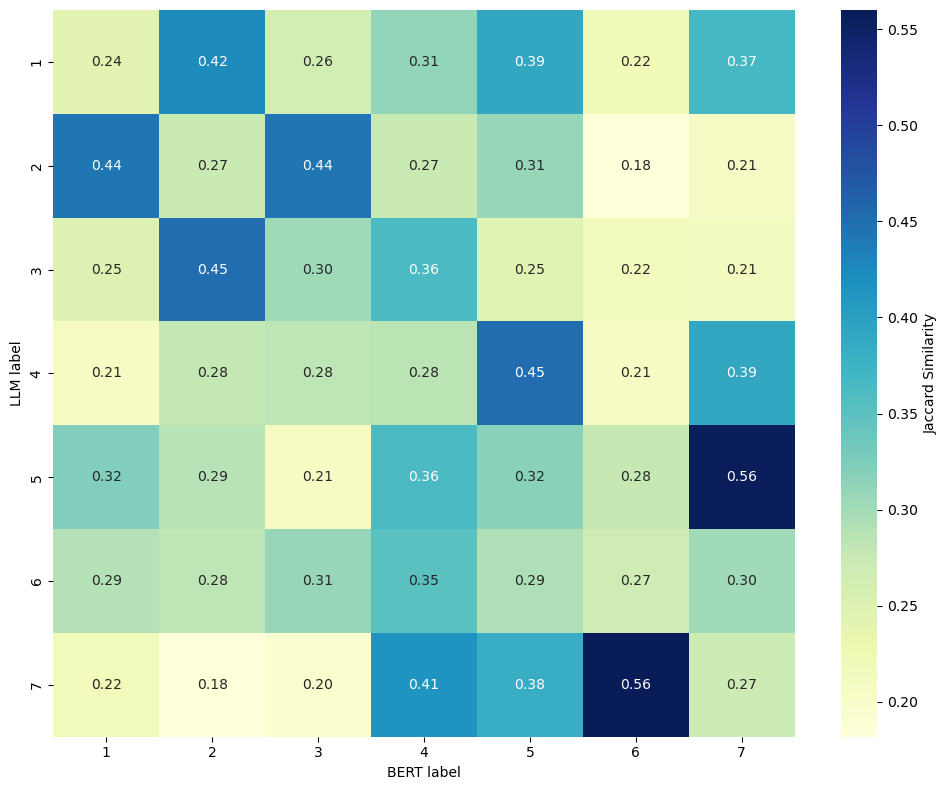

In [125]:
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Jaccard Similarity'})
plt.xlabel('BERT label')
plt.ylabel('LLM label')
plt.tight_layout()
plt.savefig('../images/jaccard_Wllm_Rbert.png')
plt.show()

## Wrong BERT, wrong LLM

In [127]:
df=df_base.copy()

In [128]:
df=df[(df['hier'] != df['humanlabel']) & (df['naed'] != df['humanlabel'])].copy()

In [129]:
df.shape

(208, 22)

### Confusion matrix

In [130]:
confusion = pd.crosstab(df['naed'], df['hier'], rownames=['LLM'], colnames=['BERT'])
print(confusion)

BERT   1  2   3  4   5   6   7
LLM                           
1     41  2   1  0  13   3   4
2      2  9   5  0   1   0   0
3      0  2  10  0   1   0   0
4      2  0   2  9   7  14   2
5      2  2   1  2  23   2   3
6      0  0   1  0   2  15   3
7      1  0   0  0   2   7  12


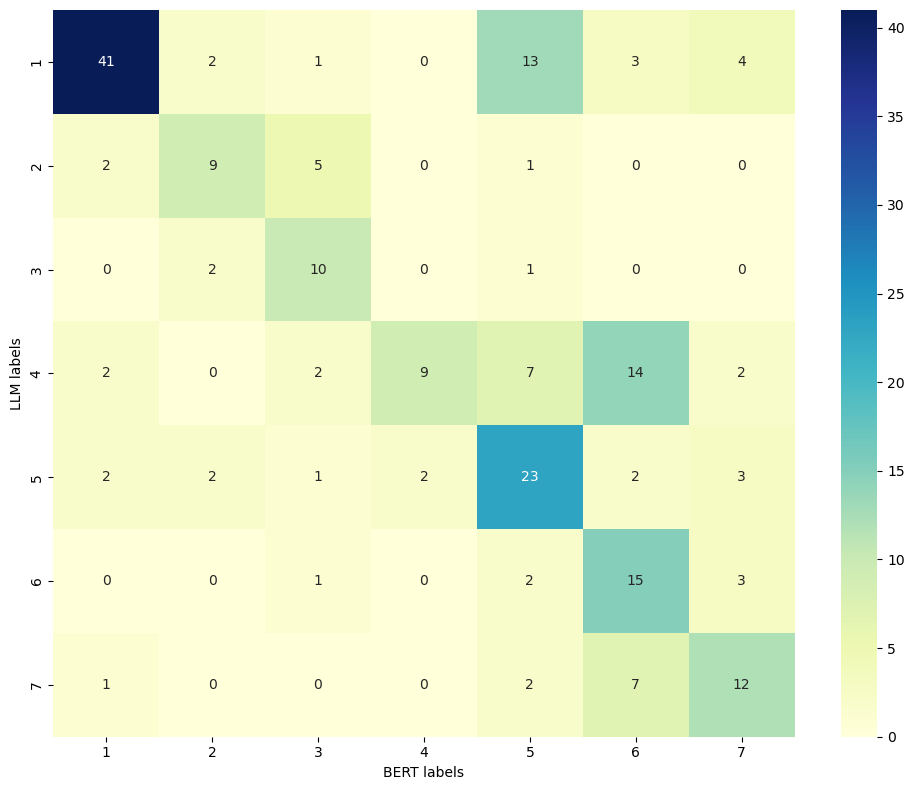

In [135]:
confusion = pd.crosstab(df['naed'], df['hier'], rownames=['LLM'], colnames=['BERT'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.ylabel('LLM labels')
plt.xlabel('BERT labels')
plt.tight_layout()
plt.show()

#### Human Label and LLM

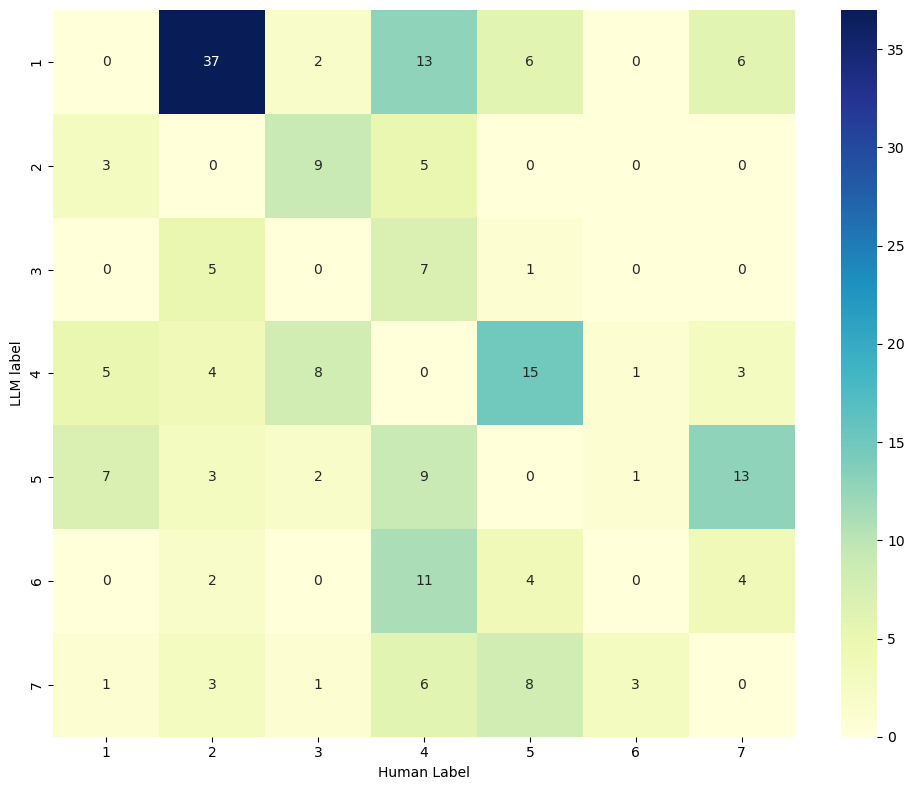

In [136]:
confusion = pd.crosstab(df['naed'], df['humanlabel'], rownames=['LLM'], colnames=['Human label'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.ylabel('LLM label')
plt.xlabel('Human Label')
plt.tight_layout()
plt.savefig('../images/37_llm.png')
plt.show()

#### Human Label and `hier`

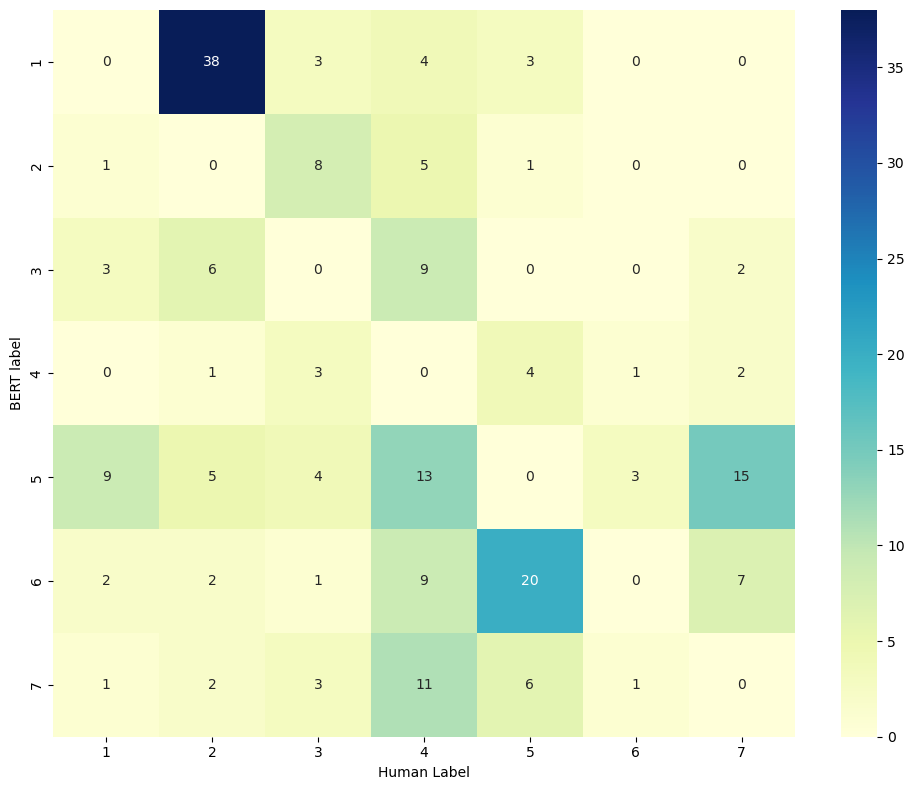

In [137]:
confusion = pd.crosstab(df['hier'], df['humanlabel'], rownames=['BERT label'], colnames=['humanlabel'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.ylabel('BERT label')
plt.xlabel('Human Label')
plt.tight_layout()
plt.savefig('../images/38_bert.png')
plt.show()

### Jaccard similarity

In [32]:
naed_tokens = get_cluster_token_sets('naed')
hier_tokens = get_cluster_token_sets('hier')

# Compute Jaccard similarity between all pairs of clusters
from collections import defaultdict

jaccard_matrix = defaultdict(dict)

for n_label, n_tokens in naed_tokens.items():
    for h_label, h_tokens in hier_tokens.items():
        intersection = len(n_tokens & h_tokens)
        union = len(n_tokens | h_tokens)
        jaccard_matrix[n_label][h_label] = intersection / union if union > 0 else 0

# Convert to DataFrame for nicer display
import pandas as pd
jaccard_df = pd.DataFrame(jaccard_matrix).T.sort_index(axis=0).sort_index(axis=1)
print(jaccard_df)

          1         2         3         4         5         6         7
1  0.607242  0.204852  0.201550  0.180879  0.344371  0.243750  0.266667
2  0.259016  0.558282  0.373737  0.183857  0.171831  0.160920  0.158576
3  0.177632  0.259669  0.618421  0.202020  0.171171  0.148936  0.160839
4  0.228155  0.193651  0.208589  0.456604  0.290168  0.433243  0.283422
5  0.236908  0.220000  0.203762  0.245033  0.517241  0.299748  0.354467
6  0.186630  0.198381  0.212355  0.269710  0.268698  0.522184  0.384083
7  0.204852  0.205323  0.187943  0.243346  0.287634  0.377581  0.542125


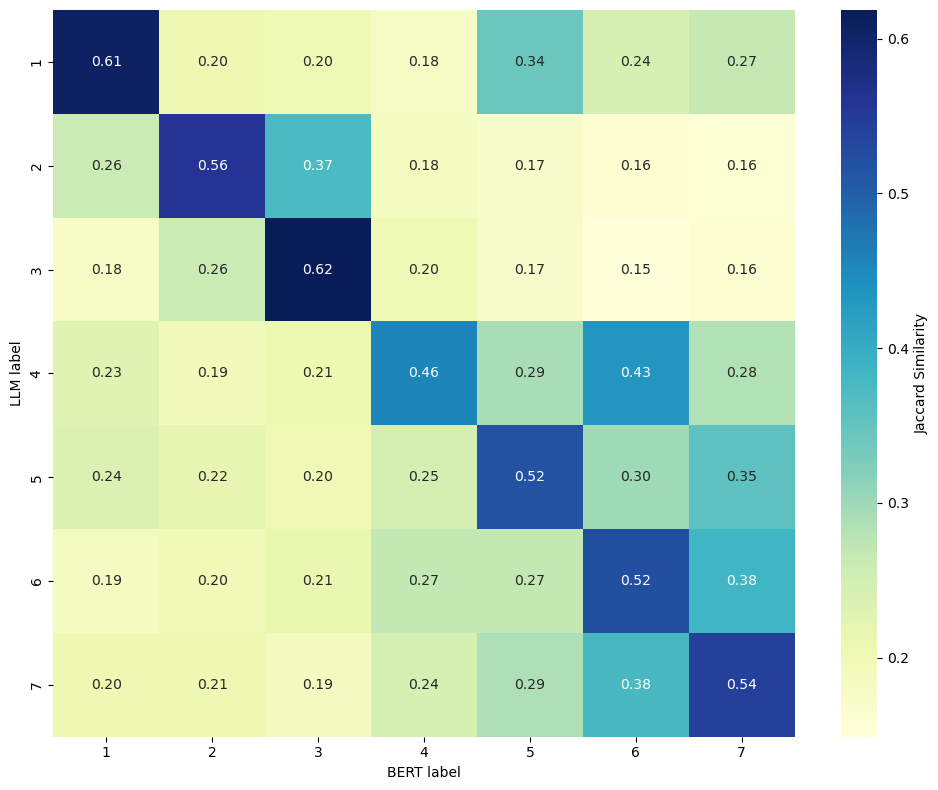

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Jaccard Similarity'})
plt.xlabel('BERT label')
plt.ylabel('LLM label')
plt.tight_layout()
plt.savefig('../images/jaccard_Wllm_Wbert.png')
plt.show()

## Wrong BERT, wrong LLM, and same choice

In [34]:
df=df_base.copy()

In [35]:
df=df[(df['hier'] != df['humanlabel']) & (df['naed'] != df['humanlabel']) & (df['naed']==df['hier'])].copy()

In [36]:
df.shape

(119, 22)

### Confusion Matrix

In [37]:
confusion = pd.crosstab(df['naed'], df['hier'], rownames=['LLM'], colnames=['BERT'])
print(confusion)

BERT   1  2   3  4   5   6   7
LLM                           
1     41  0   0  0   0   0   0
2      0  9   0  0   0   0   0
3      0  0  10  0   0   0   0
4      0  0   0  9   0   0   0
5      0  0   0  0  23   0   0
6      0  0   0  0   0  15   0
7      0  0   0  0   0   0  12


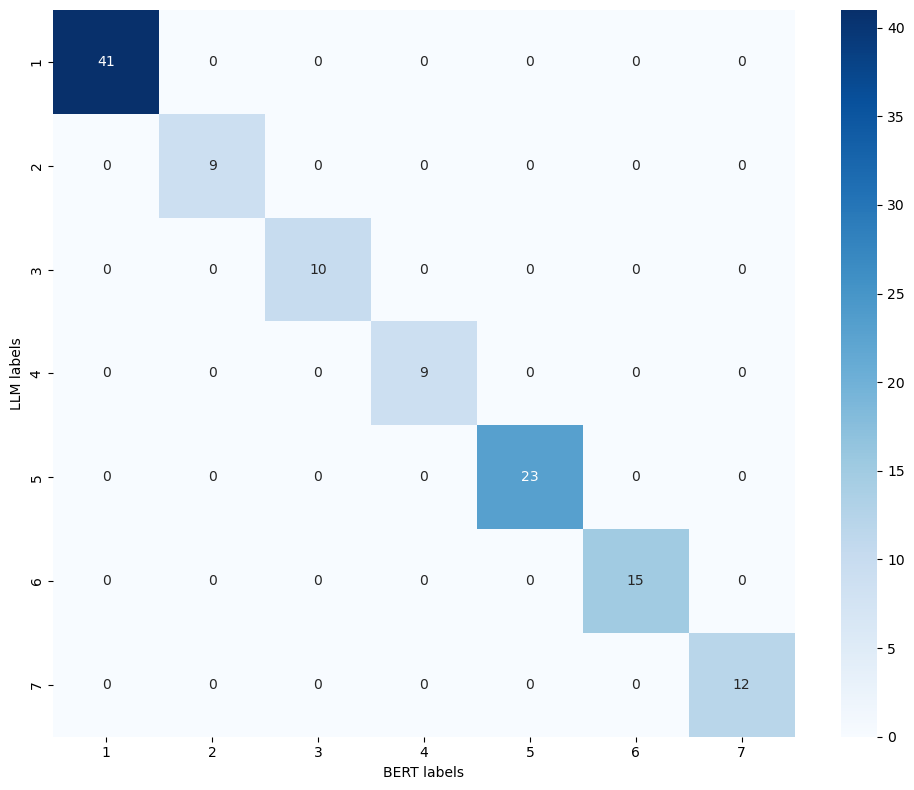

In [38]:
confusion = pd.crosstab(df['naed'], df['hier'], rownames=['LLM'], colnames=['BERT'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.ylabel('LLM labels')
plt.xlabel('BERT labels')
plt.tight_layout()
plt.show()

# Breakfast-Dessert Analysis

In [12]:
df=df_base.copy()

In [13]:
df['naed'].value_counts()

naed
2    209
5    187
4    162
1    155
7    154
3     68
6     65
Name: count, dtype: int64

In [14]:
df['hier'].value_counts()

hier
5    222
1    179
2    144
7    138
6    133
4     99
3     85
Name: count, dtype: int64

## Understanding the errors

In [15]:
df=df[df['humanlabel'].isin([1,2])]

In [16]:
df=df[(df['naed'].isin([1,2])) | (df['hier'].isin([1,2]))].copy()

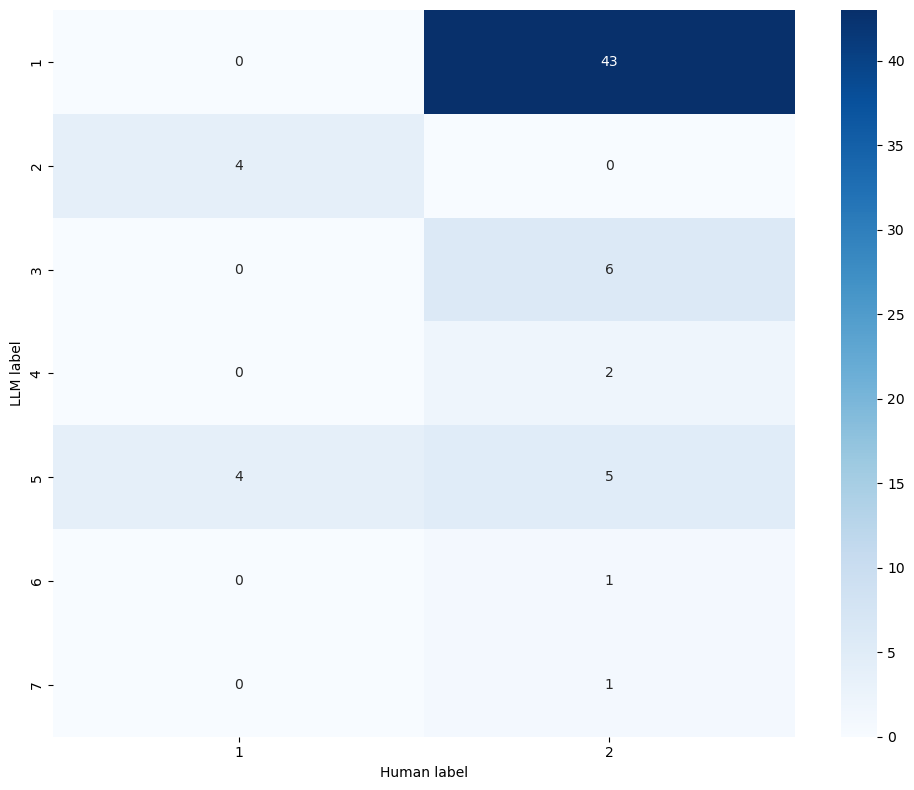

In [17]:
df_wrong=df[df['naed']!=df['humanlabel']]
confusion = pd.crosstab(df_wrong['naed'], df_wrong['humanlabel'], rownames=['naed'], colnames=['humanlabel'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.ylabel('LLM label')
plt.xlabel('Human label')
plt.tight_layout()
plt.savefig('../images/conf_12_llm_human.png')
plt.show()

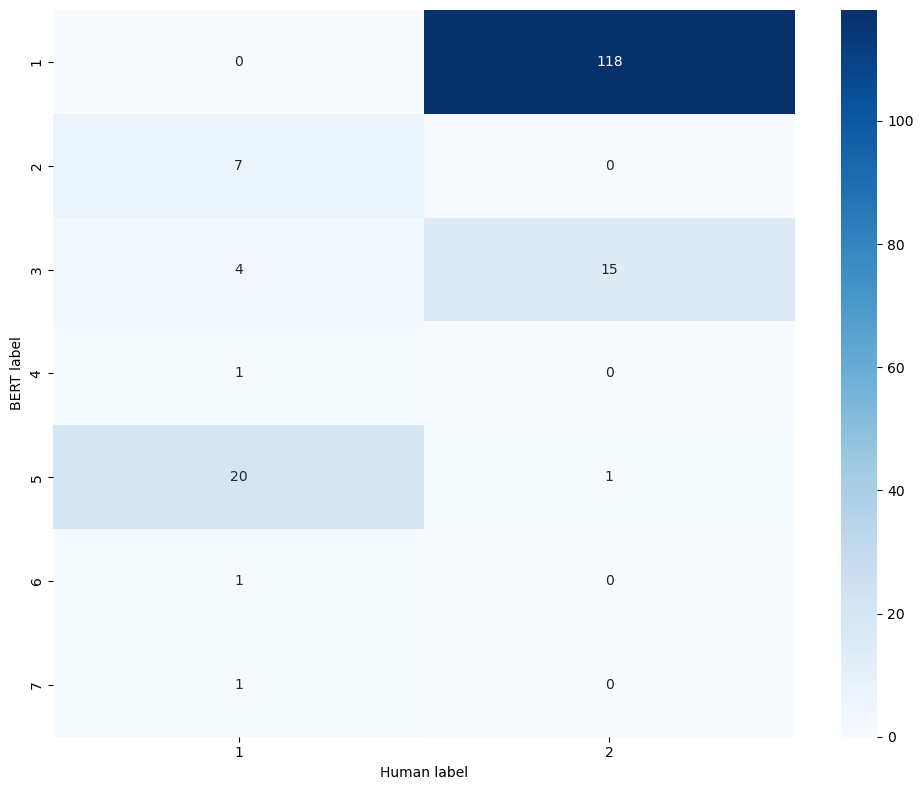

In [18]:
df_wrong=df[df['hier']!=df['humanlabel']]
confusion = pd.crosstab(df_wrong['hier'], df_wrong['humanlabel'], rownames=['hier'], colnames=['humanlabel'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.ylabel('BERT label')
plt.xlabel('Human label')
plt.tight_layout()
plt.savefig('../images/conf_12_bert_human.png')
plt.show()

In [19]:
error_df = df[(df['naed'] == 1) & (df['hier'] == 1) & (df['humanlabel'] == 2)].copy()
correct_df = df_base[(df_base['humanlabel'] == 2) & (df_base['naed'] == 2) & (df_base['hier'] == 2)].copy()

In [20]:
print(len(correct_df))
print(len(error_df))

89
35


In [21]:
error_df.head(2)

,Unnamed: 0,title,NER_list,filtered_verbs,umap_x,umap_y,dish_type_response,naed,naed_label,hier,...,avg_verbs_logodd,avg_title_logodd,avg_prompt_logodd,avg_other_logodd,humanlabel,avg_ing_logodds,avg_verb_logodds,avg_title_logodds,set_verbs,prompt
26,702,Always Soft Chocolate Chip Cookies,"[flour, baking soda, butter, sugar, brown suga...","[combine, set, pudding, add, combine, desire, ...",-4.065575,1.615065,"RATIONALE: cookies, chocolate chips, sugar, ba...",1,"Breakfast Bakes, Breads & Pancakes",1,...,0.684848,0.614096,NaN,1.088890,2,0.059599,0.002714,2.137594,"{d, s, l, ], r, m, e, \n, n, a, , c, p, [, ',...",always soft chocolate chip cookies flour bakin...
29,957,Apfel Chuechli (Swiss Apple Fritters),"[flour, cold water, vinegar, salad oil, egg, s...","[make, dip, remove]",10.696342,1.987857,"RATIONALE: Fritters, Apples, Batter, Deep-fry,...",1,"Breakfast Bakes, Breads & Pancakes",1,...,-0.927576,1.313070,-0.007723,4.070818,2,0.041018,-0.015951,3.294922,"{p, [, d, i, r, m, e, o, ', v, ], , a, k}",apfel chuechli (swiss apple fritters) flour co...


## Relative frequencies

In [22]:
ingredient_counter = Counter(ing for row in error_df['NER_list'] for ing in row)
verb_counter = Counter(v for row in error_df['filtered_verbs'] for v in row)

print('Wrong ones:')
print("Most common ingredients:")
print(ingredient_counter.most_common(20))

print("Most common verbs:")
print(verb_counter.most_common(20))

print('\nCorrect ones:')
ingredient_counter = Counter(ing for row in correct_df['NER_list'] for ing in row)
verb_counter = Counter(v for row in correct_df['filtered_verbs'] for v in row)

print("Most common ingredients:")
print(ingredient_counter.most_common(20))

print("Most common verbs:")
print(verb_counter.most_common(20))

Wrong ones:
Most common ingredients:
[('flour', 30), ('sugar', 23), ('salt', 18), ('eggs', 17), ('baking powder', 17), ('vanilla', 15), ('butter', 11), ('egg', 9), ('milk', 8), ('baking soda', 7), ('brown sugar', 7), ('oil', 6), ('soda', 5), ('water', 5), ('margarine', 5), ('buttermilk', 4), ('shortening', 4), ('oats', 3), ('yeast', 3), ('nuts', 2)]
Most common verbs:
[('add', 31), ('bake', 30), ('make', 12), ('remove', 8), ('grease', 8), ('cool', 7), ('let', 7), ('remain', 6), ('blend', 5), ('beat', 5), ('top', 5), ('set', 4), ('stir', 4), ('pour', 4), ('use', 4), ('shorten', 4), ('rise', 4), ('combine', 3), ('desire', 3), ('round', 3)]

Correct ones:
Most common ingredients:
[('sugar', 42), ('vanilla', 32), ('butter', 31), ('milk', 27), ('salt', 17), ('cream cheese', 15), ('eggs', 13), ('brown sugar', 11), ('water', 9), ('margarine', 7), ('cornstarch', 7), ('flour', 7), ('semi-sweet chocolate chips', 6), ('graham cracker crust', 6), ('powdered sugar', 6), ('chocolate chips', 6), ('pe

In [23]:
def compute_relative_diff(error_list, correct_list, top_n=30):
    error_counter = Counter([w for row in error_list for w in row])
    correct_counter = Counter([w for row in correct_list for w in row])
    
    # total
    total_error = sum(error_counter.values())
    total_correct = sum(correct_counter.values())

    # combine
    all_words = set(error_counter.keys()) | set(correct_counter.keys())

    # relative frequencies
    data = []
    for word in all_words:
        rel_error = error_counter[word] / total_error
        rel_correct = correct_counter[word] / total_correct
        diff = rel_error - rel_correct
        data.append((word, rel_error, rel_correct, diff))

    # sort by abs diff
    df_diff = pd.DataFrame(data, columns=['word', 'rel_error', 'rel_correct', 'rel_diff'])
    df_diff['abs_diff'] = df_diff['rel_diff'].abs()
    return df_diff.sort_values(by='abs_diff', ascending=False).head(top_n)

ingredient_diff_df = compute_relative_diff(error_df['NER_list']+error_df['filtered_verbs'], correct_df['NER_list']+correct_df['filtered_verbs'])
print(ingredient_diff_df)

              word  rel_error  rel_correct  rel_diff  abs_diff
300          flour   0.059172     0.006178  0.052993  0.052993
281           bake   0.059172     0.022065  0.037106  0.037106
32   baking powder   0.033531     0.000883  0.032648  0.032648
241           stir   0.007890     0.033539 -0.025650  0.025650
223           eggs   0.033531     0.011474  0.022057  0.022057
74            salt   0.035503     0.015004  0.020499  0.020499
209           make   0.023669     0.009709  0.013960  0.013960
297            egg   0.017751     0.004413  0.013338  0.013338
115   cream cheese   0.000000     0.013239 -0.013239  0.013239
65             set   0.007890     0.020300 -0.012411  0.012411
208           melt   0.003945     0.015887 -0.011942  0.011942
317            oil   0.011834     0.000000  0.011834  0.011834
278           whip   0.000000     0.011474 -0.011474  0.011474
217         grease   0.015779     0.004413  0.011366  0.011366
82     baking soda   0.013807     0.002648  0.011159  0

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18624\3633187210.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_diff, x='rel_diff', y='word', palette='coolwarm')


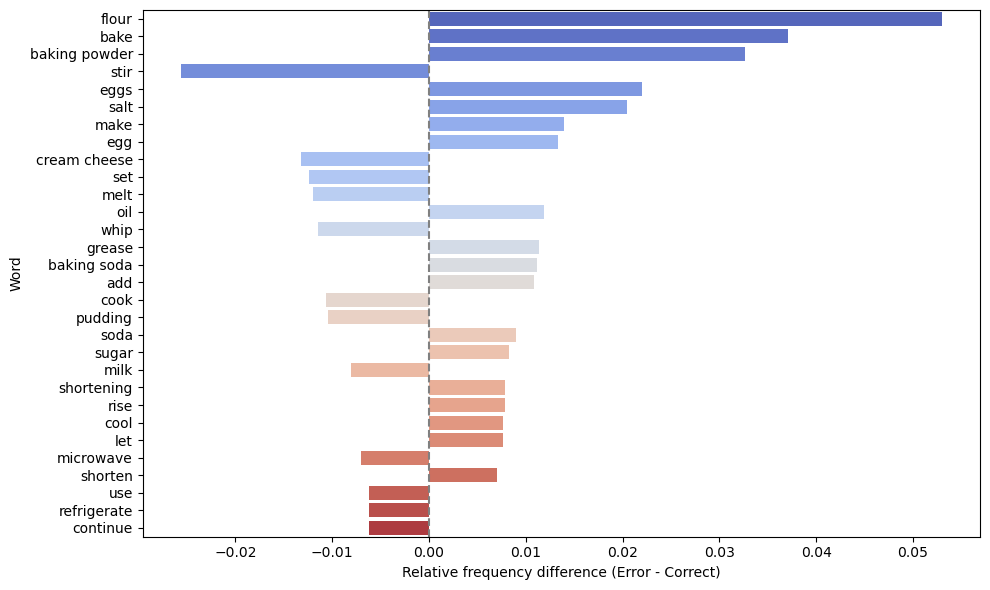

In [24]:
def plot_diff(df_diff):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_diff, x='rel_diff', y='word', palette='coolwarm')
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel('Relative frequency difference (Error - Correct)')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.savefig('../images/relative_freq_corr_wron.png')
    plt.show()

plot_diff(ingredient_diff_df)

### TF-IDF discount

In [25]:
error_texts = error_df['prompt'].astype(str).tolist()
correct_texts = correct_df['prompt'].astype(str).tolist()

# combining documents
corpus = error_texts + correct_texts
labels = ['error'] * len(error_texts) + ['correct'] * len(correct_texts)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names_out()

# to arrays
X_array = X.toarray()
X_error = X_array[:len(error_texts)]
X_correct = X_array[len(error_texts):]

# average TF-IDF score
error_mean = np.mean(X_error, axis=0)
correct_mean = np.mean(X_correct, axis=0)
rel_diff = error_mean - correct_mean

df_tfidf_diff = pd.DataFrame({
    'term': features,
    'mean_tfidf_error': error_mean,
    'mean_tfidf_correct': correct_mean,
    'rel_diff': rel_diff,
    'abs_diff': np.abs(rel_diff)
}).sort_values('abs_diff', ascending=False)

df_tfidf_diff.head(30)

,term,mean_tfidf_error,mean_tfidf_correct,rel_diff,abs_diff
365,flour,0.100371,0.009540,0.090830,0.090830
35,baking,0.091009,0.006491,0.084518,0.084518
36,baking powder,0.070743,0.001336,0.069407,0.069407
606,powder,0.068288,0.004845,0.063443,0.063443
313,cream,0.015692,0.066395,-0.050703,0.050703
523,oil,0.049226,0.000000,0.049226,0.049226
762,soda,0.051895,0.007507,0.044388,0.044388
366,flour baking,0.045801,0.001590,0.044211,0.044211
354,eggs,0.063302,0.019664,0.043638,0.043638
693,salt,0.060563,0.022475,0.038088,0.038088


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18624\140757304.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_terms, x='rel_diff', y='term', palette='coolwarm')


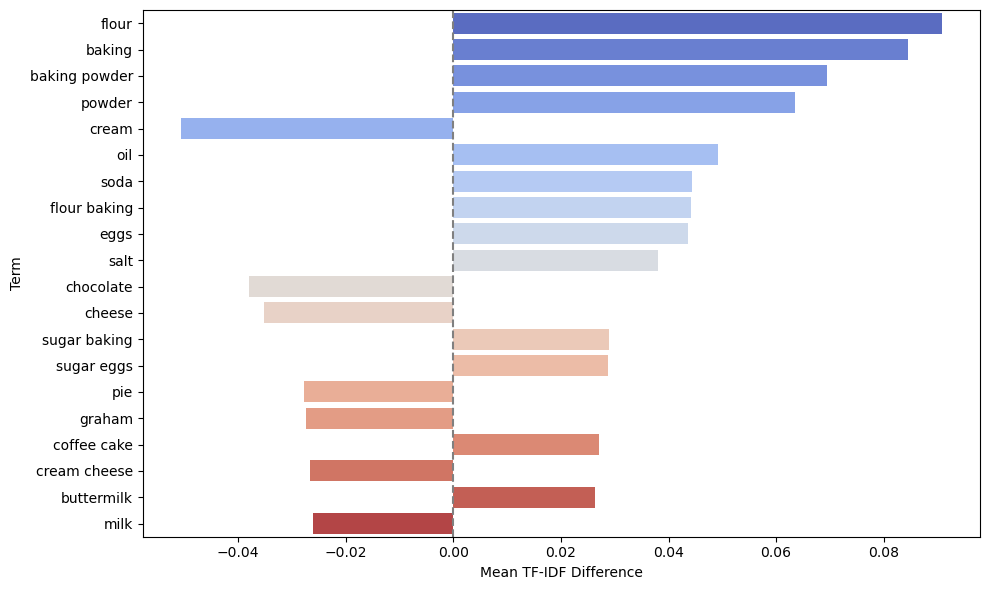

In [26]:
top_terms = df_tfidf_diff.head(20)
plt.figure(figsize=(10,6))
sns.barplot(data=top_terms, x='rel_diff', y='term', palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
# plt.title("Top 20 TF-IDF Term Differences (Error vs. Correct)")
plt.xlabel("Mean TF-IDF Difference")
plt.ylabel("Term")
plt.tight_layout()
plt.savefig('../images/tf_idf_rel_freq.png')
plt.show()

In [ ]:
df

# LLM 1, Human 2

In [53]:
error_df = df[(df['naed'] == 1) & (df['humanlabel'] == 2)].copy()
correct_df = df_base[(df_base['humanlabel'] == 2) & (df_base['naed'] == 2)].copy()

In [54]:
print(len(error_df))
len(correct_df)

43


183

## Relative frequencies

In [55]:
from collections import Counter

# Flatten list of lists
ingredient_counter = Counter(ing for row in error_df['NER_list'] for ing in row)
verb_counter = Counter(v for row in error_df['filtered_verbs'] for v in row)

print('Wrong ones:')
print("Most common ingredients:")
print(ingredient_counter.most_common(20))

print("Most common verbs:")
print(verb_counter.most_common(20))

print('\nCorrect ones:')
ingredient_counter = Counter(ing for row in correct_df['NER_list'] for ing in row)
verb_counter = Counter(v for row in correct_df['filtered_verbs'] for v in row)

print("Most common ingredients:")
print(ingredient_counter.most_common(20))

print("Most common verbs:")
print(verb_counter.most_common(20))

Wrong ones:
Most common ingredients:
[('flour', 31), ('sugar', 27), ('salt', 20), ('eggs', 18), ('baking powder', 17), ('vanilla', 16), ('butter', 15), ('egg', 10), ('milk', 9), ('brown sugar', 8), ('baking soda', 7), ('soda', 6), ('oil', 6), ('water', 6), ('margarine', 5), ('shortening', 5), ('buttermilk', 4), ('cinnamon', 4), ('nutmeg', 3), ('oats', 3)]
Most common verbs:
[('bake', 34), ('add', 33), ('make', 13), ('remove', 9), ('remain', 9), ('cool', 8), ('let', 8), ('grease', 8), ('use', 6), ('blend', 6), ('beat', 6), ('top', 6), ('pour', 5), ('shorten', 5), ('combine', 4), ('set', 4), ('stir', 4), ('degrees', 4), ('rise', 4), ('desire', 3)]

Correct ones:
Most common ingredients:
[('sugar', 104), ('vanilla', 85), ('flour', 67), ('butter', 64), ('salt', 63), ('eggs', 56), ('milk', 41), ('baking soda', 29), ('brown sugar', 27), ('water', 22), ('baking powder', 22), ('nuts', 19), ('margarine', 18), ('cream cheese', 18), ('cinnamon', 18), ('chocolate chips', 17), ('egg', 17), ('peanut

In [56]:
from collections import Counter
import pandas as pd

def compute_relative_diff(error_list, correct_list, top_n=30):
    error_counter = Counter([w for row in error_list for w in row])
    correct_counter = Counter([w for row in correct_list for w in row])

    total_error = sum(error_counter.values())
    total_correct = sum(correct_counter.values())
    all_words = set(error_counter.keys()) | set(correct_counter.keys())

    data = []
    for word in all_words:
        rel_error = error_counter[word] / total_error
        rel_correct = correct_counter[word] / total_correct
        diff = rel_error - rel_correct
        data.append((word, rel_error, rel_correct, diff))

    df_diff = pd.DataFrame(data, columns=['word', 'rel_error', 'rel_correct', 'rel_diff'])
    df_diff['abs_diff'] = df_diff['rel_diff'].abs()
    return df_diff.sort_values(by='abs_diff', ascending=False).head(top_n)

ingredient_diff_df = compute_relative_diff(error_df['NER_list']+error_df['filtered_verbs'], correct_df['NER_list']+correct_df['filtered_verbs'])
print(ingredient_diff_df)

                word  rel_error  rel_correct  rel_diff  abs_diff
169            flour   0.052811     0.025670  0.027140  0.027140
398    baking powder   0.028961     0.008429  0.020532  0.020532
149             stir   0.006814     0.023755 -0.016940  0.016940
312             make   0.022147     0.009579  0.012568  0.012568
391              egg   0.017036     0.006513  0.010522  0.010522
199             salt   0.034072     0.024138  0.009934  0.009934
8                let   0.013629     0.004215  0.009414  0.009414
76              eggs   0.030664     0.021456  0.009208  0.009208
26              bake   0.057922     0.049808  0.008113  0.008113
290              oil   0.010221     0.002299  0.007923  0.007923
371             whip   0.001704     0.009579 -0.007875  0.007875
423             melt   0.003407     0.010728 -0.007321  0.007321
217     cream cheese   0.000000     0.006897 -0.006897  0.006897
168             rise   0.006814     0.000000  0.006814  0.006814
134             beat   0.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10008\3398644499.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_diff, x='rel_diff', y='word', palette='coolwarm')


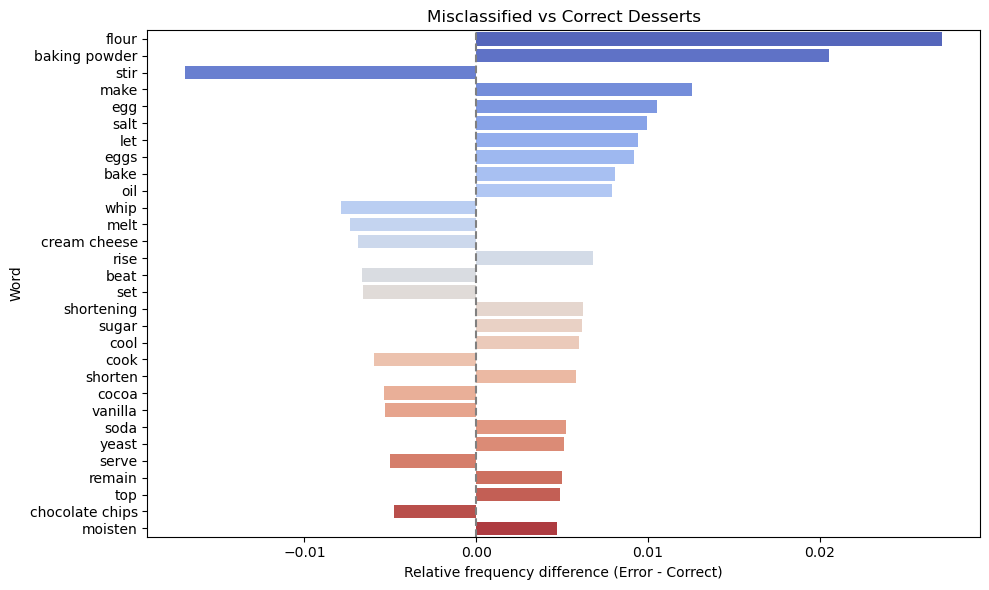

In [57]:
def plot_diff(df_diff, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_diff, x='rel_diff', y='word', palette='coolwarm')
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(title)
    plt.xlabel('Relative frequency difference (Error - Correct)')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

plot_diff(ingredient_diff_df, 'Misclassified vs Correct Desserts')

### TF-IDF discount

In [58]:
error_texts = error_df['prompt'].astype(str).tolist()
correct_texts = correct_df['prompt'].astype(str).tolist()

corpus = error_texts + correct_texts
labels = ['error'] * len(error_texts) + ['correct'] * len(correct_texts)

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names_out()

X_array = X.toarray()
X_error = X_array[:len(error_texts)]
X_correct = X_array[len(error_texts):]

error_mean = np.mean(X_error, axis=0)
correct_mean = np.mean(X_correct, axis=0)
rel_diff = error_mean - correct_mean

df_tfidf_diff = pd.DataFrame({
    'term': features,
    'mean_tfidf_error': error_mean,
    'mean_tfidf_correct': correct_mean,
    'rel_diff': rel_diff,
    'abs_diff': np.abs(rel_diff)
}).sort_values('abs_diff', ascending=False)

df_tfidf_diff.head(30)

,term,mean_tfidf_error,mean_tfidf_correct,rel_diff,abs_diff
14,baking powder,0.061831,0.016414,0.045417,0.045417
107,chocolate,0.013373,0.055470,-0.042097,0.042097
613,powder,0.060197,0.019847,0.040350,0.040350
217,flour,0.075186,0.038261,0.036925,0.036925
13,baking,0.069257,0.033470,0.035787,0.035787
218,flour baking,0.042352,0.011444,0.030907,0.030907
474,oil,0.042902,0.012056,0.030847,0.030847
131,coffee cake,0.026040,0.000000,0.026040,0.026040
669,rolls,0.024782,0.000000,0.024782,0.024782
89,cheese,0.000000,0.023534,-0.023534,0.023534


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10008\675418575.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_terms, x='rel_diff', y='term', palette='coolwarm')


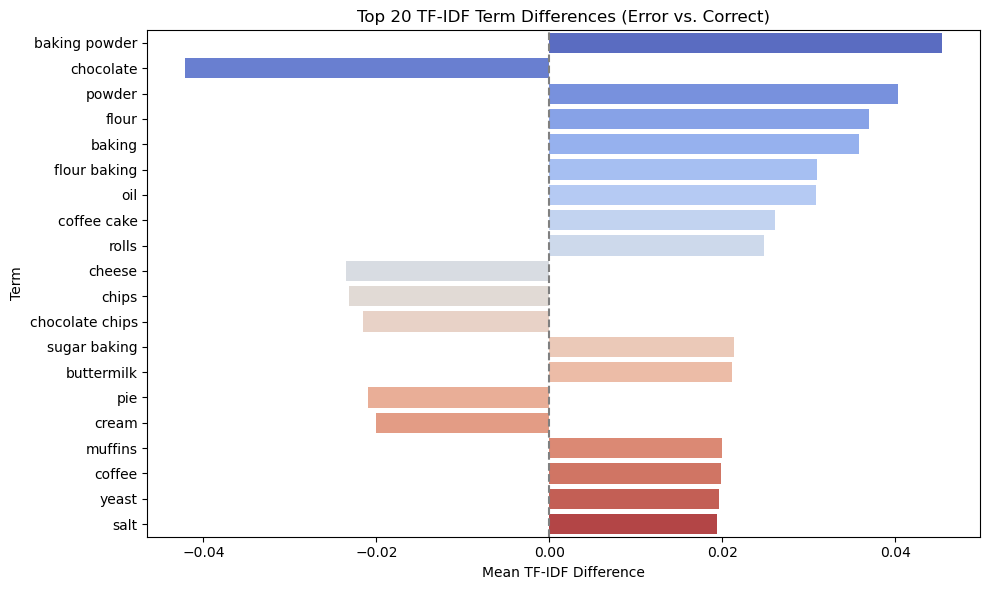

In [59]:
top_terms = df_tfidf_diff.head(20)
plt.figure(figsize=(10,6))
sns.barplot(data=top_terms, x='rel_diff', y='term', palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Top 20 TF-IDF Term Differences (Error vs. Correct)")
plt.xlabel("Mean TF-IDF Difference")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

# BERT 1, Human Label and LLM 2

In [60]:
error_df = df_base[(df_base['hier']==1) & (df_base['naed'] == 2) & (df_base['humanlabel'] == 2)].copy()
correct_df = df_base[(df_base['hier'] == 2) & (df_base['humanlabel'] == 2) & (df_base['naed'] == 2)].copy()

In [61]:
print(len(error_df))
len(correct_df)

80


89

In [62]:
df=pd.concat([error_df,correct_df])

In [63]:
df['flag']=np.where(df['humanlabel']!=df['hier'],1,0)

In [64]:
df.groupby(['naed','flag'])[['avg_ingredients_logodd','avg_verb_logodds','avg_title_logodds']].agg(['mean','std','count'])

avg_ingredients_logodd                 avg_verb_logodds            \
                            mean       std count             mean       std   
naed flag                                                                     
2    0                  1.562186  0.947378    64         0.007632  0.020697   
     1                  1.429239  0.674609    66         0.020012  0.033516   

                avg_title_logodds                  
          count              mean       std count  
naed flag                                          
2    0       89          2.699950  2.829221    89  
     1       80          2.842019  2.595109    80

In [65]:
df=df[df['avg_ingredients_logodd']<=0].copy()

In [66]:
df.groupby(['naed','flag'])[['avg_ingredients_logodd','avg_verb_logodds','avg_title_logodds']].agg(['mean','std','count'])

avg_ingredients_logodd                avg_verb_logodds            \
                            mean      std count             mean       std   
naed flag                                                                    
2    0                 -0.248775  0.21073     2         0.011318  0.002694   
     1                 -0.549586      NaN     1        -0.011625       NaN   

                avg_title_logodds                  
          count              mean       std count  
naed flag                                          
2    0        2          2.579245  0.785281     2  
     1        1          0.287229       NaN     1

## Relative frequencies

In [67]:
ingredient_counter = Counter(ing for row in error_df['NER_list'] for ing in row)
verb_counter = Counter(v for row in error_df['filtered_verbs'] for v in row)

print('Wrong ones:')
print("Most common ingredients:")
print(ingredient_counter.most_common(20))

print("Most common verbs:")
print(verb_counter.most_common(20))

print('\nCorrect ones:')
ingredient_counter = Counter(ing for row in correct_df['NER_list'] for ing in row)
verb_counter = Counter(v for row in correct_df['filtered_verbs'] for v in row)

print("Most common ingredients:")
print(ingredient_counter.most_common(20))

print("Most common verbs:")
print(verb_counter.most_common(20))

Wrong ones:
Most common ingredients:
[('flour', 58), ('sugar', 54), ('vanilla', 50), ('salt', 44), ('eggs', 43), ('butter', 30), ('baking soda', 26), ('baking powder', 21), ('brown sugar', 16), ('cinnamon', 13), ('milk', 12), ('nuts', 12), ('soda', 12), ('chocolate chips', 11), ('egg', 11), ('cocoa', 10), ('water', 10), ('margarine', 10), ('peanut butter', 9), ('white sugar', 7)]
Most common verbs:
[('bake', 101), ('add', 88), ('beat', 22), ('grease', 22), ('stir', 18), ('blend', 17), ('pour', 14), ('come', 14), ('insert', 12), ('remain', 12), ('make', 11), ('remove', 11), ('spread', 11), ('combine', 11), ('melt', 10), ('sift', 10), ('set', 10), ('cool', 10), ('serve', 8), ('preheat', 8)]

Correct ones:
Most common ingredients:
[('sugar', 42), ('vanilla', 32), ('butter', 31), ('milk', 27), ('salt', 17), ('cream cheese', 15), ('eggs', 13), ('brown sugar', 11), ('water', 9), ('margarine', 7), ('cornstarch', 7), ('flour', 7), ('semi-sweet chocolate chips', 6), ('graham cracker crust', 6),

In [68]:
def compute_relative_diff(error_list, correct_list, top_n=30):
    error_counter = Counter([w for row in error_list for w in row])
    correct_counter = Counter([w for row in correct_list for w in row])

    total_error = sum(error_counter.values())
    total_correct = sum(correct_counter.values())
    all_words = set(error_counter.keys()) | set(correct_counter.keys())
    
    data = []
    for word in all_words:
        rel_error = error_counter[word] / total_error
        rel_correct = correct_counter[word] / total_correct
        diff = rel_error - rel_correct
        data.append((word, rel_error, rel_correct, diff))

    df_diff = pd.DataFrame(data, columns=['word', 'rel_error', 'rel_correct', 'rel_diff'])
    df_diff['abs_diff'] = df_diff['rel_diff'].abs()
    return df_diff.sort_values(by='abs_diff', ascending=False).head(top_n)

ingredient_diff_df = compute_relative_diff(error_df['NER_list']+error_df['filtered_verbs'],correct_df['NER_list']+correct_df['filtered_verbs'])
print(ingredient_diff_df)

              word  rel_error  rel_correct  rel_diff  abs_diff
23            bake   0.077752     0.022065  0.055687  0.055687
153          flour   0.044650     0.006178  0.038471  0.038471
67            eggs   0.033102     0.011474  0.021628  0.021628
136           stir   0.013857     0.033539 -0.019682  0.019682
178           salt   0.033872     0.015004  0.018868  0.018868
152            add   0.067744     0.050309  0.017436  0.017436
93     baking soda   0.020015     0.002648  0.017368  0.017368
355  baking powder   0.016166     0.000883  0.015284  0.015284
220           milk   0.009238     0.023831 -0.014593  0.014593
352            set   0.007698     0.020300 -0.012602  0.012602
196         grease   0.016936     0.004413  0.012523  0.012523
205        pudding   0.000000     0.012357 -0.012357  0.012357
195   cream cheese   0.001540     0.013239 -0.011700  0.011700
264         remove   0.008468     0.019417 -0.010949  0.010949
269        vanilla   0.038491     0.028244  0.010248  0

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10008\3398644499.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_diff, x='rel_diff', y='word', palette='coolwarm')


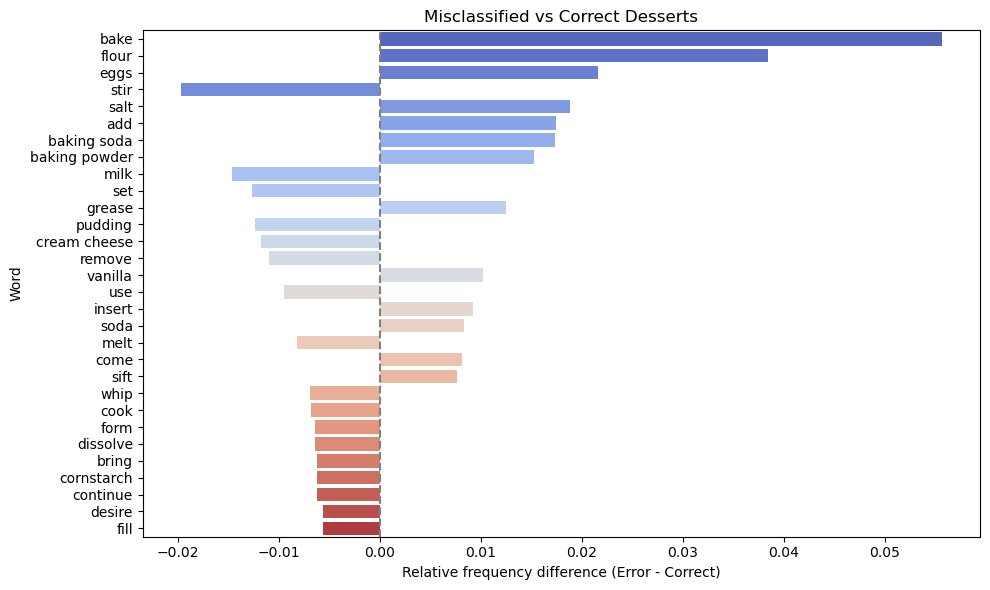

In [69]:
def plot_diff(df_diff, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_diff, x='rel_diff', y='word', palette='coolwarm')
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(title)
    plt.xlabel('Relative frequency difference (Error - Correct)')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

plot_diff(ingredient_diff_df, 'Misclassified vs Correct Desserts')

### TF-IDF discount

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

# 1. Extract prompt texts as lists of documents (strings)
error_texts = error_df['prompt'].astype(str).tolist()
correct_texts = correct_df['prompt'].astype(str).tolist()

# 2. Combine the documents into one corpus
corpus = error_texts + correct_texts
labels = ['error'] * len(error_texts) + ['correct'] * len(correct_texts)

# 3. TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names_out()

# 4. Convert to arrays and split
X_array = X.toarray()
X_error = X_array[:len(error_texts)]
X_correct = X_array[len(error_texts):]

# 5. Compute average TF-IDF scores per feature
error_mean = np.mean(X_error, axis=0)
correct_mean = np.mean(X_correct, axis=0)
rel_diff = error_mean - correct_mean

# 6. Package into DataFrame
df_tfidf_diff = pd.DataFrame({
    'term': features,
    'mean_tfidf_error': error_mean,
    'mean_tfidf_correct': correct_mean,
    'rel_diff': rel_diff,
    'abs_diff': np.abs(rel_diff)
}).sort_values('abs_diff', ascending=False)

# 7. Display top differing terms
df_tfidf_diff.head(30)

,term,mean_tfidf_error,mean_tfidf_correct,rel_diff,abs_diff
178,flour,0.080052,0.008414,0.071637,0.071637
12,baking,0.069986,0.005540,0.064446,0.064446
128,cream,0.017112,0.075256,-0.058144,0.058144
683,soda,0.057438,0.006015,0.051424,0.051424
163,eggs,0.057482,0.017599,0.039882,0.039882
14,baking soda,0.044737,0.005352,0.039384,0.039384
13,baking powder,0.038957,0.001535,0.037421,0.037421
520,powder,0.041606,0.005866,0.035740,0.035740
615,salt,0.056277,0.020912,0.035365,0.035365
72,cheese,0.005732,0.037837,-0.032105,0.032105


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10008\2484478288.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_terms, x='rel_diff', y='term', palette='coolwarm')


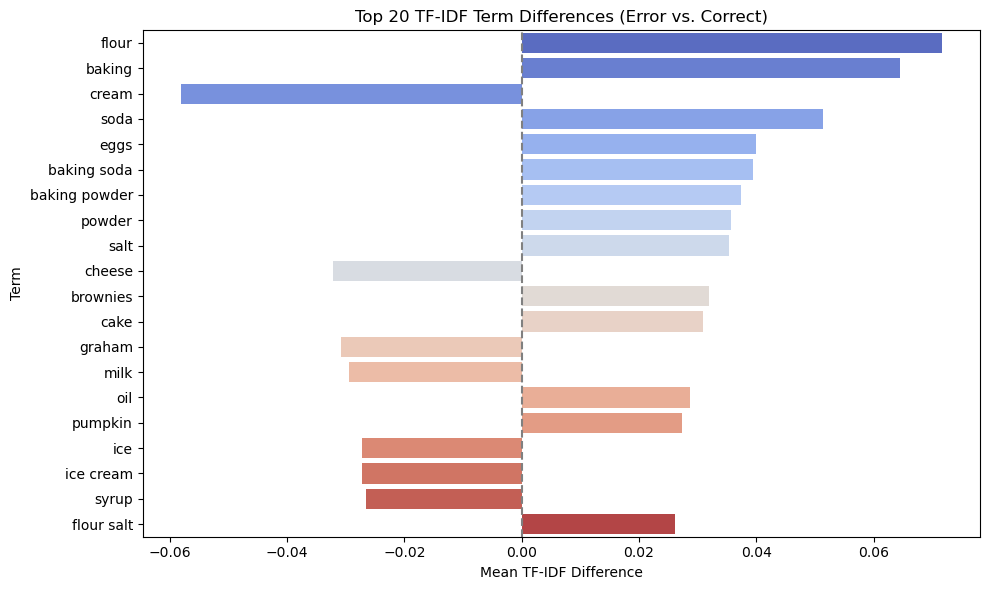

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

top_terms = df_tfidf_diff.head(20)
plt.figure(figsize=(10,6))
sns.barplot(data=top_terms, x='rel_diff', y='term', palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Top 20 TF-IDF Term Differences (Error vs. Correct)")
plt.xlabel("Mean TF-IDF Difference")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

# LLM wrong


In [72]:
df=df_base.copy()
df['flag']=np.where(df['naed']!=df['humanlabel'],1,0)

In [73]:
df.groupby(['naed','flag'])[['avg_ingredients_logodd','avg_verb_logodds','avg_title_logodds']].agg(['mean','std'])

avg_ingredients_logodd           avg_verb_logodds            \
                            mean       std             mean       std   
naed flag                                                               
1    0                  0.949870  1.171250         0.008894  0.025480   
     1                  0.580812  1.224952         0.009954  0.024818   
2    0                  1.530229  0.846138         0.012219  0.028416   
     1                  0.600115  1.055737         0.008537  0.020042   
3    0                  2.303135  1.829742         0.012934  0.022345   
     1                  0.905678  1.205868         0.011766  0.017532   
4    0                  0.607031  0.780454         0.007844  0.022784   
     1                  0.437671  0.674549         0.002655  0.017330   
5    0                  0.642400  0.721221         0.004192  0.014379   
     1                  0.382770  0.889725         0.009088  0.022856   
6    0                  0.701459  0.669144         0.014428  0.019857   
     1                  0.290934  1.017836         0.007772  0.024141   
7    0                  1.467473  1.738545         0.005286  0.016825   
     1                  0.882432  1.372748         0.009873  0.020242   

          avg_title_logodds            
                       mean       std  
naed flag                              
1    0             1.998755  2.609588  
     1             2.385215  2.747873  
2    0             2.696157  2.644826  
     1             2.066063  2.450847  
3    0             3.220505  3.415675  
     1             1.669254  2.150559  
4    0             1.625262  1.899086  
     1             1.778651  2.244568  
5    0             2.025610  2.229781  
     1             2.437640  3.650635  
6    0             1.778827  2.099179  
     1             1.625986  1.564575  
7    0             1.972014  2.415342  
     1             1.983763  2.100506

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10008\3915133703.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


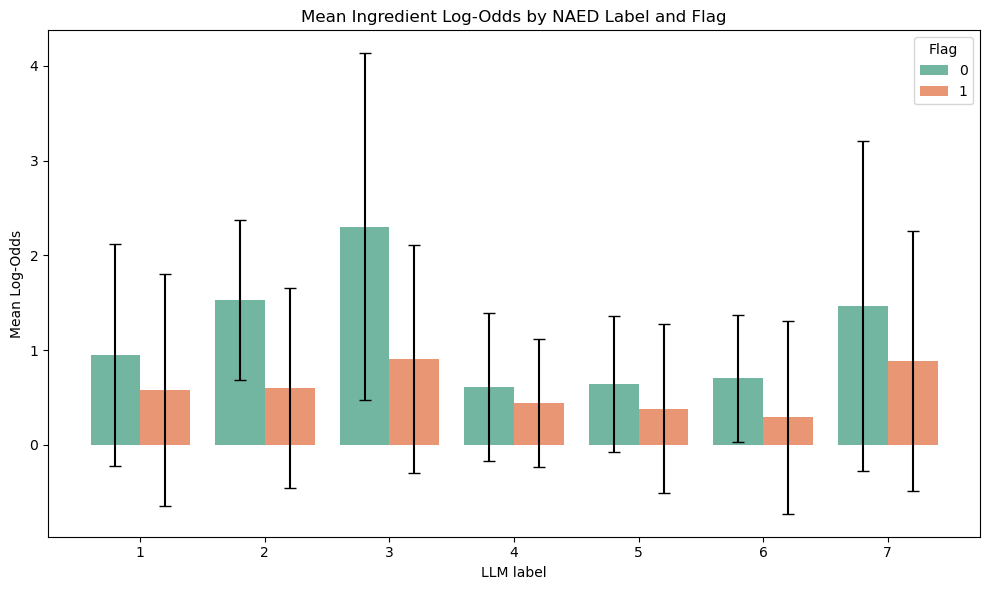

In [74]:
agg_df = df.groupby(['naed','flag'])['avg_ingredients_logodd'].agg(['mean','std']).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(
    data=agg_df,
    x='naed', y='mean', hue='flag',
    ci=None,
    palette='Set2'
)

for i, row in agg_df.iterrows():
    plt.errorbar(
        x=i // 2 + (0.2 if row['flag'] else -0.2),  # shift to match bar position
        y=row['mean'],
        yerr=row['std'],
        fmt='none',
        c='black',
        capsize=4
    )

plt.title("Mean Ingredient Log-Odds by NAED Label and Flag")
plt.ylabel("Mean Log-Odds")
plt.xlabel("LLM label")
plt.legend(title="Flag")
plt.tight_layout()
plt.show()

In [75]:
df=df_base.copy()
df=df[df['avg_ingredients_logodd']<=0].copy()
df['flag']=np.where(df['naed']!=df['humanlabel'],1,0)

In [76]:
df.groupby(['naed','flag'])['avg_ingredients_logodd'].agg(['mean','std','count'])

mean       std  count
naed flag                           
1    0    -0.448098  0.361840      9
     1    -0.666556  0.550611     21
2    0    -0.349045  0.228836      3
     1    -0.726360  0.534245      6
3    0    -0.229506  0.168161      2
     1    -0.361951  0.454360      2
4    0    -0.548766  0.508493     16
     1    -0.567140  0.323389      6
5    0    -0.275019  0.264439     16
     1    -0.693186  0.574493     15
6    0    -0.764165  0.551199      3
     1    -0.810424  1.248487      7
7    0    -0.372939  0.289094      5
     1    -0.400702  0.531141      4

In [77]:
df.groupby('flag')['avg_ingredients_logodd'].agg(['count','mean','median','std'])

,count,mean,median,std
flag,,,,
0,54,-0.423644,-0.367114,0.391221
1,61,-0.658297,-0.475696,0.629014


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10008\1417525424.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


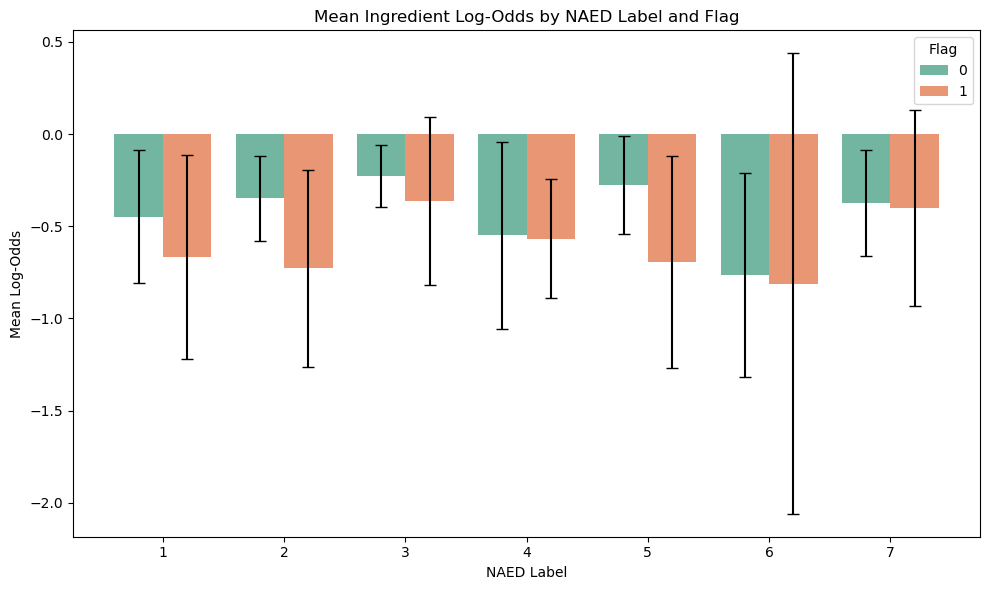

In [78]:
agg_df = df.groupby(['naed','flag'])['avg_ingredients_logodd'].agg(['mean','std']).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(
    data=agg_df,
    x='naed', y='mean', hue='flag',
    ci=None,
    palette='Set2'
)

for i, row in agg_df.iterrows():
    plt.errorbar(
        x=i // 2 + (0.2 if row['flag'] else -0.2),  # shift to match bar position
        y=row['mean'],
        yerr=row['std'],
        fmt='none',
        c='black',
        capsize=4
    )

plt.title("Mean Ingredient Log-Odds by NAED Label and Flag")
plt.ylabel("Mean Log-Odds")
plt.xlabel("NAED Label")
plt.legend(title="Flag")
plt.tight_layout()
plt.show()

# Negative Log-odd interpretation

In [79]:
df[(df['flag']==1) & (df['avg_ing_logodds']<=0)][['title','NER_list','filtered_verbs','dish_type_response','naed','hier','avg_prompt_logodd','avg_ingredients_logodd','avg_ing_logodds','avg_other_logodd','avg_title_logodds']].head(10)

,title,NER_list,filtered_verbs,dish_type_response,naed,hier,avg_prompt_logodd,avg_ingredients_logodd,avg_ing_logodds,avg_other_logodd,avg_title_logodds
17,Acorn Squash Souffle,"[acorn, eggs, butter, sugar, milk, nutmeg, cin...","[cut, remove, cut, do, remove, smooth, beat, b...","RATIONALE: acorn squash, souffle, eggs, milk, ...",6,6,NaN,-0.526023,-0.029443,NaN,1.301254
20,Airport Bob'S Green Beans,"[bacon, butter, brown sugar]","[do, drain, add, dissolve, set, pot, cook, dra...","RATIONALE: bacon, butter, brown sugar, cook, d...",7,6,NaN,-0.104452,-0.005530,NaN,4.306494
35,Apples and Noodles,"[egg noodles, apples, brown sugar, ground cinn...","[bake, accord, drain, bottom, bake, sprinkle, ...","RATIONALE: pasta, apples, cinnamon, sweet, bak...",5,2,0.704755,-0.771824,-0.009351,-1.019893,0.208777
133,Brown Bag Special,"[chicken, celery, red bell pepper, green onion...","[divide, slice, remain, serve]","RATIONALE: Chicken salad, bread\nNUMBER = 5\n\...",5,3,NaN,-0.033288,-0.024316,NaN,-0.351722
147,Buttered Hot And Sweet Nibbles,"[pretzels, crackers, butter, chili powder, sugar]","[set, melt, add, stir, toss, bake, spread, sti...","RATIONALE: snacks, savory, butter, chili powde...",1,2,NaN,-0.218589,-0.010991,1.812362,0.405244
149,Butternut Squash Croquettes,"[butternut, butter, salt, nutmeg, flour, egg]","[add, mash, add, ball, beat, fry, turn]","RATIONALE: vegetable fritters, vegetable side ...",4,6,1.539128,-0.746866,-0.032439,5.319152,1.809940
232,Collard Green Dish,"[collard greens, red onions, fresh garlic, ext...","[cut, stem, leave, leave, size, keep, add, cov...","RATIONALE: collard greens, vegetable dish, sav...",7,6,-1.523500,-0.133753,-0.002733,0.253825,1.414970
357,Excellent Microwave Sweet Pickles,"[salt, turmeric, vinegar, sugar, celery, cucum...","[measure, microwave, bowl, microwave, uncover,...","RATIONALE: Pickles, vinegar, sugar, microwave\...",3,4,NaN,-0.040670,-0.004367,NaN,1.216229
376,Filbert Yams,"[yams, honey, margarine, lemon juice, nuts, ma...","[arrange, grease, bake, chop]","RATIONALE: Sweet potatoes, honey glaze, bake\n...",2,5,1.834219,-0.099766,-0.013883,NaN,2.471053
407,Gala'S Goulash,"[lean ground beef, onion, garlic powder, tomat...","[add, continue, cook, stir, add, coat, serve]","RATIONALE: ground beef, onion, tomato soup, ki...",7,5,1.758265,-0.168147,-0.023837,0.529663,0.888912


In [80]:
df[(df['flag']==0) & (df['avg_title_logodds']<=0)][['title','NER_list','filtered_verbs','dish_type_response','naed','hier','avg_prompt_logodd','avg_ingredients_logodd','avg_ing_logodds','avg_other_logodd','avg_title_logodds']].head(10)

,title,NER_list,filtered_verbs,dish_type_response,naed,hier,avg_prompt_logodd,avg_ingredients_logodd,avg_ing_logodds,avg_other_logodd,avg_title_logodds
70,Bar Clam Bread,"[clams, cream cheese, mayonnaise, lemon juice,...","[cut, pour, bake, burn, serve]","RATIONALE: bread, clams, garlic, mayonnaise, c...",1,5,NaN,-0.681671,0.020614,NaN,-0.339997
354,Ethel's Sweet Potatoes and Apple Casserole,"[sweet potatoes, cooking apples, sugar, ground...","[bake, inch, bake, drizzle, remain, bake]","RATIONALE: sweet potatoes, apples, sugar, cinn...",5,2,NaN,-0.516333,-0.025784,-1.019893,-0.521220
636,Mushroom And Gruyere Cheese Omelet,"[butter, shallots, mushrooms, lemon, white win...","[chop, stir, add, add]","RATIONALE: omelet, eggs, mushrooms, cheese, sh...",1,4,NaN,-0.794773,-0.000732,1.616091,-0.263819


In [81]:
print(df[df['title']=='Oven Baked Chicken And Biscuits'][['dish_type_response','NER_list','filtered_verbs','humanlabel','naed','hier']].iloc[0])
print(df[df['title']=='Oven Baked Chicken And Biscuits']['dish_type_response'].iloc[0])

print(df[df['title']=='Quickie Kajmak'][['dish_type_response','NER_list','filtered_verbs','humanlabel','naed','hier']].iloc[0])
print(df[df['title']=='Quickie Kajmak']['dish_type_response'].iloc[0])

dish_type_response    RATIONALE: chicken, baking, biscuits, oven, fl...
NER_list              [flour, salt, pepper, shortening, paprika, chi...
filtered_verbs                                                    [set]
humanlabel                                                            7
naed                                                                  5
hier                                                                  4
Name: 680, dtype: object
RATIONALE: chicken, baking, biscuits, oven, flour, salt, pepper, shortening, paprika
NUMBER = 5

This recipe falls under the category of Pasta & Vegetable Casseroles/Bakes because the main components are chicken and biscu
dish_type_response    RATIONALE: Dairy spread, Feta cheese, Sour cre...
NER_list                        [feta cheese, sour cream, cream cheese]
filtered_verbs               [sieve, drain, drain, blend, bring, serve]
humanlabel                                                            4
naed                             

In [82]:
df=df_base.copy()

In [83]:
df_sorted = df.sort_values('avg_ingredients_logodd', ascending=True)

In [84]:
df_sorted[df_sorted['title']=='Rich Venetian Hot Chocolate ~ The Hot Chocolate Of Your Dreams'][['dish_type_response','NER_list','filtered_verbs','humanlabel','naed','hier']].iloc[0]
print(df[df['title']=='Rich Venetian Hot Chocolate ~ The Hot Chocolate Of Your Dreams']['dish_type_response'].iloc[0])

RATIONALE: Hot chocolate, chocolate, milk, melt, whisk, rest
NUMBER = 6

This recipe falls under the Hot Chocolate category in the Soups, Stews & One-Pots category (number 6) as it is a warm, creamy beverage


In [85]:
print(df_sorted[df_sorted['title']=='Celery Sauce'][['dish_type_response','NER_list','filtered_verbs','humanlabel','naed','hier']].iloc[0])
print(df[df['title']=='Celery Sauce']['dish_type_response'].iloc[0])

dish_type_response    RATIONALE: Sauce, vegetable-based, thickened, ...
NER_list                            [butter, celery, flour, milk, salt]
filtered_verbs        [add, stir, continue, stir, add, thicken, stir...
humanlabel                                                            4
naed                                                                  4
hier                                                                  6
Name: 180, dtype: object
RATIONALE: Sauce, vegetable-based, thickened, milk-based, seasoned
NUMBER = 4

This recipe falls under the Sauces, Slaws, Dips & Dressings category (number 4) because it is a sauce made from vegetables (


In [86]:
print(df_sorted[df_sorted['title']=='Georgia Corn Bread Dressing'][['dish_type_response','NER_list','filtered_verbs','humanlabel','naed','hier']].iloc[0])
print(df[df['title']=='Georgia Corn Bread Dressing']['dish_type_response'].iloc[0])

dish_type_response    RATIONALE: cornbread, dressing, vegetables, on...
NER_list                                     [celery, onion, egg, eggs]
filtered_verbs                       [chop, dry, make, add, boil, bake]
humanlabel                                                            4
naed                                                                  1
hier                                                                  1
Name: 415, dtype: object
RATIONALE: cornbread, dressing, vegetables, onion, celery, baking
NUMBER = 1 (Breakfast Bakes, Breads & Pancakes)

Explanation:
This recipe is for a corn bread dressing, which is a type of stuff
